In [1]:
# Import necessary libraries
import os
import sys

os.chdir(r"C:\Users\vibho\Documents\VSA")

# Add the utils folder to the system path so we can import custom modules
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("utils"))

import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from utils.reproducibility_utils import seed_everything
from utils.data_loading import load_data, load_test_data, feature_names
from prime import ProxyBank, PrimeConfig, PrimeLoss

# Set the plotting style for better-looking visualizations
plt.style.available
plt.style.use('seaborn-v0_8')


In [2]:
# Set random seed for reproducibility across runs
# This ensures that your results will be the same every time you run the notebook
seed_everything(42)  # for reproducibility

# Load the Data

In [3]:
print("Loading train data...")
train_dataloader, val_dataloader, pipeline = load_data(
    train_path = "sensing-the-drift/datasets_challenge/train",  # Path to training data
    train_ratio = 0.8,  # Use 80% for training, 20% for validation
    batchsize = 512,  # Number of samples per batch
    # columns_to_standardize = feature_names,  # Option to specify which columns to standardize
    columns_to_drop = ["sideSlip", "vyCG", "time", "longitude","latitude"],  # Remove these from features
    sequence_length = 20,  # Number of time steps in each sequence (t-19 to t0)
    threshold = True,  # Enable velocity thresholding
    threshold_value = 3.0,  # Only keep samples where vehicle speed > 3 m/s
    threshold_column = "vxCG",  # Column to apply threshold on (longitudinal velocity)
    target = "sideSlip",  # The variable we want to predict
    scaling = True,  # Apply standardization to features
    seed = 42,  # Random seed for train/val split
)

Loading train data...
sensing-the-drift/datasets_challenge/train\train_part_001.csv
sensing-the-drift/datasets_challenge/train\train_part_002.csv
sensing-the-drift/datasets_challenge/train\train_part_003.csv
sensing-the-drift/datasets_challenge/train\train_part_004.csv
sensing-the-drift/datasets_challenge/train\train_part_005.csv
sensing-the-drift/datasets_challenge/train\train_part_006.csv
sensing-the-drift/datasets_challenge/train\train_part_007.csv
sensing-the-drift/datasets_challenge/train\train_part_008.csv
sensing-the-drift/datasets_challenge/train\train_part_009.csv
sensing-the-drift/datasets_challenge/train\train_part_010.csv
sensing-the-drift/datasets_challenge/train\train_part_011.csv
sensing-the-drift/datasets_challenge/train\train_part_012.csv
sensing-the-drift/datasets_challenge/train\train_part_013.csv
sensing-the-drift/datasets_challenge/train\train_part_014.csv
sensing-the-drift/datasets_challenge/train\train_part_015.csv
sensing-the-drift/datasets_challenge/train\train

# Visualize an Example of a single sample

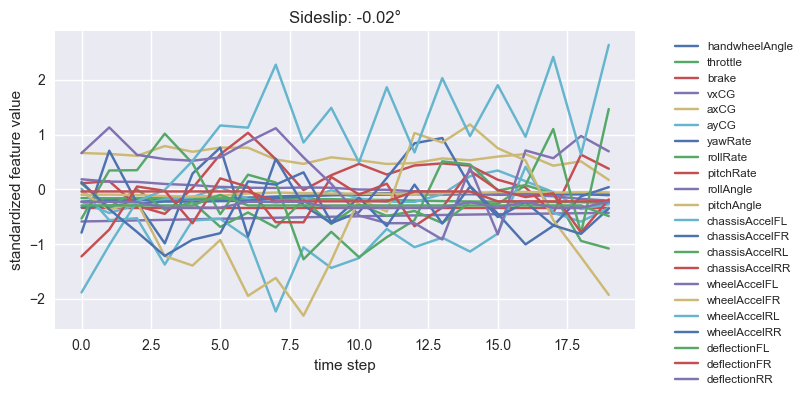

In [4]:
# Get one batch of data from the training dataloader
X, y = next(iter(train_dataloader))

# Visualize the first sample in the batch
plt.figure(figsize=(8,4))
plt.plot(X[0,:,:], label=feature_names)  # Plot all 22 features over 20 time steps
plt.title("Sideslip: "+str(round(y[0].item(),2))+"°")  # Show the target value
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.xlabel("time step")
plt.ylabel("standardized feature value")
plt.show()

# Train an example model

## Simple RNN

In [5]:
class RNN(nn.Module):
    """
    Recurrent Neural Network for sideslip angle prediction.
    
    Architecture:
    1. RNN Layer - Processes sequential input
    2. Fully Connected Layer - Transforms RNN output
    3. Output Layer - Produces final prediction
    
    Dropout layers are included to prevent overfitting.
    """
    def __init__(self, input_size, output_size=1, rnn_units=64, fc_units=64, 
                 activation_fct=nn.ReLU(), dropout=[0.2, 0, 0], rnn_nonlinearity='tanh'):
        super(RNN, self).__init__()
        
        # RNN layer: processes the sequence and captures temporal dependencies
        self.rnn_layer = nn.RNN(input_size=input_size, hidden_size=rnn_units, 
                                num_layers=1, nonlinearity=rnn_nonlinearity, batch_first=True)
        
        # Fully connected layers for processing RNN output
        self.fc = nn.Linear(rnn_units, fc_units)
        self.output_layer = nn.Linear(fc_units, output_size)
        
        # Dropout layers to prevent overfitting (randomly zeros out neurons during training)
        self.dropout1 = nn.Dropout(dropout[0])  # Applied to input
        self.dropout2 = nn.Dropout(dropout[1])  # Applied after RNN
        self.dropout3 = nn.Dropout(dropout[2])  # Applied after FC layer
        
        self.activation_fct = activation_fct
 
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        x = self.dropout1(x)
        
        # Process sequence through RNN
        x, _ = self.rnn_layer(x)  # Output shape: (batch_size, sequence_length, rnn_units)
        
        # Take only the last time step's output (t0)
        x = x[:, -1, :]  # Shape: (batch_size, rnn_units)
        
        x = self.dropout2(x)
        x = self.activation_fct(self.fc(x))  # Apply fully connected layer with activation
        x = self.dropout3(x)
        x = self.output_layer(x)  # Final prediction
        
        return x

In [6]:
# Set device for computation (CPU or GPU)
device = "cuda"  # Change to "cuda" if you have a GPU available

# Model hyperparameters
input_size = X.shape[2]  # Number of features (22 in this case)
rnn_units = 64  # Number of units in RNN hidden state
fc_units = 64  # Number of units in fully connected layer
output_size = 1  # Single output (sideslip angle)
lr = 0.0003  # Learning rate for optimizer

# Initialize the model with specified architecture
model = RNN(
    input_size=input_size, 
    output_size=output_size,
    rnn_units=rnn_units,
    fc_units=fc_units,
    dropout=[0.0, 0.1, 0.05], # Dropout rates for [input, after_rnn, after_fc]
).to(device)

# Define loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) - measures average prediction error
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for weight updates

In [7]:
# Feature dimension for PRIME = size of your FC layer output
feature_dim = model.fc.out_features  # equals your fc_units

# Compute target min/max from your training data (scalar y)
def _targets_min_max(loader, device):
    ymin = None; ymax = None
    for _, y in loader:
        y = y.to(device).view(-1, 1)
        ymin = y.min() if ymin is None else torch.minimum(ymin, y.min())
        ymax = y.max() if ymax is None else torch.maximum(ymax, y.max())
    return ymin, ymax

y_min, y_max = _targets_min_max(train_dataloader, device)

# Create proxies + config + PRIME loss
C = 32  # number of proxies (try 16–64)
pb  = ProxyBank(y_min=y_min, y_max=y_max, C=C, feature_dim=feature_dim, target_dim=1, device=torch.device(device))
cfg = PrimeConfig(tau_t=5.0, tau_f=5.0, alpha=0.1, lambda_p=0.5, lambda_a=1.0)
prime = PrimeLoss(pb, cfg)

## Checking if there are nonfinite parameters

# 1) device should be a torch.device, not the raw string "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) check a couple of batches for NaN/Inf
import math, itertools
def _finite(x): 
    return torch.isfinite(x).all().item()

for split_name, loader in [("train", train_dataloader), ("val", val_dataloader)]:
    for i, (xb, yb) in zip(range(2), loader):  # check first 2 batches
        ok = _finite(xb) and _finite(yb)
        print(f"[{split_name}] batch {i+1}: finite={ok}, x_dtype={xb.dtype}, y_dtype={yb.dtype}, x_minmax=({xb.min().item():.4g},{xb.max().item():.4g}), y_minmax=({yb.min().item():.4g},{yb.max().item():.4g})")
        if not ok:
            raise ValueError(f"Non-finite values in {split_name} batch {i+1}. Fix preprocessing (NaN/Inf).")

# 3) plain model forward on 1 batch (no PRIME) must be finite
model.eval()
(xb, yb) = next(iter(train_dataloader))
xb = xb.to(device); yb = yb.to(device).view(-1,1)
with torch.no_grad():
    pred = model(xb)
    base_loss = criterion(pred, yb)
print(f"[sanity] plain forward finite? pred={torch.isfinite(pred).all().item()}, loss={torch.isfinite(base_loss).item()}, loss={float(base_loss):.6g}")


In [12]:
# Training configuration
num_epochs = 100
early_stop_thresh = 10
best_loss = np.inf
best_epoch = -1
best_model_state = None

train_curve = []
val_curve = []

for epoch in range(num_epochs):
    running_loss = 0.0

    # Accumulators for PRIME components (averaged at epoch end)
    sum_L_reg = 0.0
    sum_L_proxy = 0.0
    sum_L_align = 0.0
    sum_L_total = 0.0
    train_steps_used = 0

    # ========== TRAINING PHASE ==========
    model.train()
    for step, (x, y) in enumerate(train_dataloader, start=1):
        X, y = x.to(device), y.to(device).reshape([len(y), 1])

        optimizer.zero_grad()

        # --- reproduce your forward to expose z ---
        X_d1 = model.dropout1(X)
        rnn_out, _ = model.rnn_layer(X_d1)
        h_last = rnn_out[:, -1, :]
        h_last = model.dropout2(h_last)
        z = model.activation_fct(model.fc(h_last))       # [B, fc_units]
        y_hat = model.output_layer(model.dropout3(z))    # [B, 1]

        # Losses
        reg_loss = criterion(y_hat, y)
        total_loss, logs = prime(reg_loss, z_batch=z, y_batch=y)

        total_loss.backward()
        optimizer.step()

        # Your original training curve used base reg_loss
        running_loss += float(reg_loss)

        # Accumulate PRIME logs to average later
        sum_L_reg   += float(logs["L_reg"])
        sum_L_proxy += float(logs["L_proxy"])
        sum_L_align += float(logs["L_align"])
        sum_L_total += float(logs["L_total"])
        train_steps_used += 1

    # Averages
    avg_train_loss = running_loss / max(train_steps_used, 1)
    train_curve.append(avg_train_loss)

    avg_L_reg   = sum_L_reg   / max(train_steps_used, 1)
    avg_L_proxy = sum_L_proxy / max(train_steps_used, 1)
    avg_L_align = sum_L_align / max(train_steps_used, 1)
    avg_L_total = sum_L_total / max(train_steps_used, 1)

    # ========== VALIDATION PHASE ==========
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_step, (x, y) in enumerate(val_dataloader, start=1):
            X_val, y_val = x.to(device), y.to(device).reshape([len(y), 1])
            val_loss = criterion(model(X_val), y_val)
            running_val_loss += float(val_loss)

    avg_val_loss = running_val_loss / max(val_step, 1)
    val_curve.append(avg_val_loss)

    # Print epoch summary INCLUDING PRIME components
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f} | "
        f"L_reg: {avg_L_reg:.5f} | L_proxy: {avg_L_proxy:.5f} | "
        f"L_align: {avg_L_align:.5f} | L_total: {avg_L_total:.5f}",
        end=""
    )

    # ========== EARLY STOPPING & MODEL CHECKPOINTING ==========
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'proxy_state_dict': pb.state_dict(),
            'loss': best_loss
        }, 'best_model.pth')
        print(f"  → New best validation loss: {best_loss:.5f}")
    elif epoch - best_epoch > early_stop_thresh:
        print(f"  → Early stopping triggered at epoch {epoch+1} (best epoch: {best_epoch+1})")
        break
    else:
        print("")

# ========== LOAD BEST MODEL ==========
if best_epoch != -1:
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'proxy_state_dict' in checkpoint:
        pb.load_state_dict(checkpoint['proxy_state_dict'])
    print(f"\n✓ Best model from epoch {best_epoch+1} loaded (Val Loss: {best_loss:.5f})")
else:
    print("\n⚠ No improvement found, using current model")


C:\Users\vibho\AppData\Local\Temp\ipykernel_6076\3681383103.py:44: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  running_loss += float(reg_loss)


Epoch 1/100 | Train Loss: 0.55869 | Val Loss: 0.32211 | L_reg: 0.55869 | L_proxy: -917.98975 | L_align: 3.28574 | L_total: -455.15045  → New best validation loss: 0.32211
Epoch 2/100 | Train Loss: 0.31085 | Val Loss: 0.26133 | L_reg: 0.31085 | L_proxy: -917.98975 | L_align: 3.19948 | L_total: -455.48454  → New best validation loss: 0.26133
Epoch 3/100 | Train Loss: 0.26733 | Val Loss: 0.23004 | L_reg: 0.26733 | L_proxy: -917.98975 | L_align: 3.18184 | L_total: -455.54571  → New best validation loss: 0.23004
Epoch 4/100 | Train Loss: 0.24743 | Val Loss: 0.21506 | L_reg: 0.24743 | L_proxy: -917.98975 | L_align: 3.17245 | L_total: -455.57499  → New best validation loss: 0.21506
Epoch 5/100 | Train Loss: 0.23732 | Val Loss: 0.20437 | L_reg: 0.23732 | L_proxy: -917.98975 | L_align: 3.16631 | L_total: -455.59124  → New best validation loss: 0.20437
Epoch 6/100 | Train Loss: 0.22852 | Val Loss: 0.19784 | L_reg: 0.22852 | L_proxy: -917.98975 | L_align: 3.16137 | L_total: -455.60498  → New best

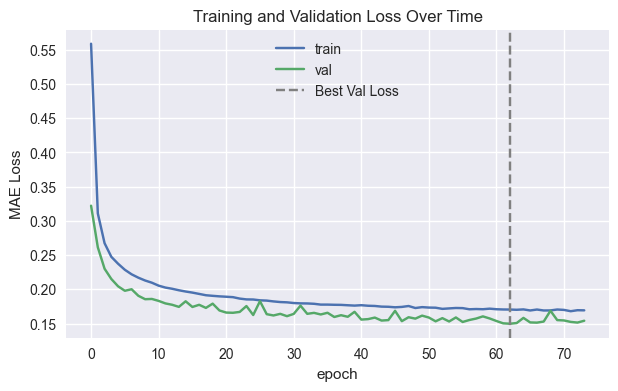

In [13]:
# Visualize training progress
plt.figure(figsize=(7, 4))
plt.plot(train_curve, label="train")
plt.plot(val_curve, label="val")
plt.axvline(x=best_epoch, color='gray', linestyle='--', label='Best Val Loss')
plt.xlabel("epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.title("Training and Validation Loss Over Time")
plt.show()

# Evaluate the Training

## Verification Step

Let's verify that we correctly loaded the best model by evaluating it one more time on the validation set. The loss should match the best validation loss from training.

In [14]:
# Evaluate the loaded model on validation set
model.eval()
running_val_loss = 0
with torch.no_grad():
    for val_step, (x, y) in enumerate(val_dataloader):
        X_val, y_val = x.to(device), y.to(device).reshape([len(y), 1])
        val_loss = criterion(model(X_val), y_val)
        running_val_loss += val_loss.item()

avg_val_loss = running_val_loss / val_step

print(f"Final Evaluation on Validation Set - MAE Loss: {avg_val_loss:.5f}")

Final Evaluation on Validation Set - MAE Loss: 0.15264


## Visual Sanity Check

In [15]:
# Load complete training data (unshuffled) for visualization
# This uses the same preprocessing pipeline to ensure consistency
train_dataloader_unshuffled = load_test_data(
    test_path="sensing-the-drift/datasets_challenge/train",
    batchsize=512,
    pipeline=pipeline,  # Use the same preprocessing as training
    load_anonymized_data=False  # We have ground truth for training data
)

sensing-the-drift/datasets_challenge/train\train_part_001.csv
sensing-the-drift/datasets_challenge/train\train_part_002.csv
sensing-the-drift/datasets_challenge/train\train_part_003.csv
sensing-the-drift/datasets_challenge/train\train_part_004.csv
sensing-the-drift/datasets_challenge/train\train_part_005.csv
sensing-the-drift/datasets_challenge/train\train_part_006.csv
sensing-the-drift/datasets_challenge/train\train_part_007.csv
sensing-the-drift/datasets_challenge/train\train_part_008.csv
sensing-the-drift/datasets_challenge/train\train_part_009.csv
sensing-the-drift/datasets_challenge/train\train_part_010.csv
sensing-the-drift/datasets_challenge/train\train_part_011.csv
sensing-the-drift/datasets_challenge/train\train_part_012.csv
sensing-the-drift/datasets_challenge/train\train_part_013.csv
sensing-the-drift/datasets_challenge/train\train_part_014.csv
sensing-the-drift/datasets_challenge/train\train_part_015.csv
sensing-the-drift/datasets_challenge/train\train_part_016.csv
sensing-

## Interactive Visualization with Plotly

In [16]:
import plotly.graph_objects as go

# Set model to evaluation mode
model.eval()

# Storage for predictions and ground truth
total_loss = 0  
preds = []
ground_truths = []

# Generate predictions for all training data
with torch.no_grad():
    for step, (x, y) in enumerate(train_dataloader_unshuffled):
        X, y = x.to(device), y.to(device).reshape([len(y), 1])

        pred = model(X)
        loss = criterion(pred, y)
        total_loss += loss.item()
        
        # Store predictions and ground truth
        preds.append(pred.reshape(-1).cpu().numpy())
        ground_truths.append(y.reshape(-1).cpu().numpy())

    print(f"Avg. Loss: {total_loss/step}")
    
    # Concatenate all batches into single arrays
    ground_truths = np.concatenate(ground_truths)
    preds = np.concatenate(preds)

# Create interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=ground_truths, mode='lines', name='truth', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=preds.flatten(), mode='lines', name='pred', line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Ground Truth vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

Avg. Loss: 0.1492203784067086


# Participating in the Challenge

In [17]:
print("\nLoading test data...")
test_dataloader = load_test_data(test_path = "sensing-the-drift/datasets_challenge/test",
                                 batchsize = 512,
                                 pipeline = pipeline, 
                                 load_anonymized_data=True)


Loading test data...
sensing-the-drift/datasets_challenge/test\test_part_001.csv
sensing-the-drift/datasets_challenge/test\test_part_002.csv
sensing-the-drift/datasets_challenge/test\test_part_003.csv
sensing-the-drift/datasets_challenge/test\test_part_004.csv
sensing-the-drift/datasets_challenge/test\test_part_005.csv
sensing-the-drift/datasets_challenge/test\test_part_006.csv
sensing-the-drift/datasets_challenge/test\test_part_007.csv
sensing-the-drift/datasets_challenge/test\test_part_008.csv
sensing-the-drift/datasets_challenge/test\test_part_009.csv
sensing-the-drift/datasets_challenge/test\test_part_010.csv
sensing-the-drift/datasets_challenge/test\test_part_011.csv


In [18]:
# Generate predictions on test set
model.eval()
total_loss = 0  
test_preds = []
test_ground_truths = []  # Will contain placeholder values (all zeros)

with torch.no_grad():
    for step, (x, y) in enumerate(test_dataloader):
        X, y = x.to(device), y.to(device).reshape([len(y), 1])

        pred = model(X)
        loss = criterion(pred, y)
        # Note: loss is meaningless here since y contains placeholder values
        
        # Store predictions
        test_preds.append(pred.reshape(-1).cpu().numpy())
        test_ground_truths.append(y.reshape(-1).cpu().numpy())

    # Concatenate all batches
    test_ground_truths = np.concatenate(test_ground_truths)
    test_preds = np.concatenate(test_preds)
    
print("Shape of Predictions", test_preds.shape)

Shape of Predictions (49328,)


## Expected Output Shape

In [19]:
# Visualize test predictions (note: test_ground_truths are just zeros here)
fig = go.Figure()
fig.add_trace(go.Scatter(y=test_ground_truths, mode='lines', name='placeholder (zeros)', 
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(y=test_preds.flatten(), mode='lines', name='predictions', 
                         line=dict(color='red'), opacity=0.8))
fig.update_layout(
    title='Test Set: Placeholder vs Predictions',
    xaxis_title='Sample Index',
    yaxis_title='Sideslip Angle (degrees)',
    width=1200,
    height=500
)
fig.show()

In [20]:
# Save predictions in the required format for submission
y_pred = pd.DataFrame({"predicted_sideslip": test_preds})
y_pred["id"] = range(len(test_preds))  # Add sample IDs (0 to 49327)

# Save to CSV file
y_pred.to_csv("predictions.csv", index=False)

print(f"✓ Predictions saved to 'predictions.csv'")
print(f"✓ Total samples: {len(test_preds)}")
print(f"✓ Ready for submission to the competition!")

✓ Predictions saved to 'predictions.csv'
✓ Total samples: 49328
✓ Ready for submission to the competition!


# Understanding the Challenge Evaluation

**The Imbalanced Regression Problem:** Real-world datasets are rarely perfectly balanced. In sideslip angle prediction, most driving happens with small sideslip angles (around 0°), but **the most critical safety situations occur at extreme angles** where vehicles are close to losing control. Following Yang et al.'s "Delving into Deep Imbalanced Regression" approach, we divide our dataset into three regions based on data frequency:

- 📘 **Many-Shot Region (90% of data - Blue)**
    - Contains the most frequent sideslip angles (mostly around 0°)
    - Represents normal driving conditions
    - **Baseline requirement**: Your model must maintain MAE ≤ 0.2° here

- 🟠 **Medium-Shot Region (9% of data - Orange)** 
    - Moderately frequent angles
    - Transition between normal and extreme conditions

- 🔴 **Few-Shot Region (1% of data - Red)**
    - **Most critical for safety**: Extreme sideslip angles
    - Represents dangerous driving situations (ice, emergency maneuvers)
    - **Primary evaluation metric**: This is where your model performance matters most!

**🎯 Challenge Goal**
> **"How can we train a neural network to excel in critical situations (few-shot) without sacrificing performance in common scenarios (many-shot)?"**

Let's visualize this distribution to understand what you're working with:

In [21]:
dist_df = pd.read_csv("sensing-the-drift/sideSlip_distribution.csv")

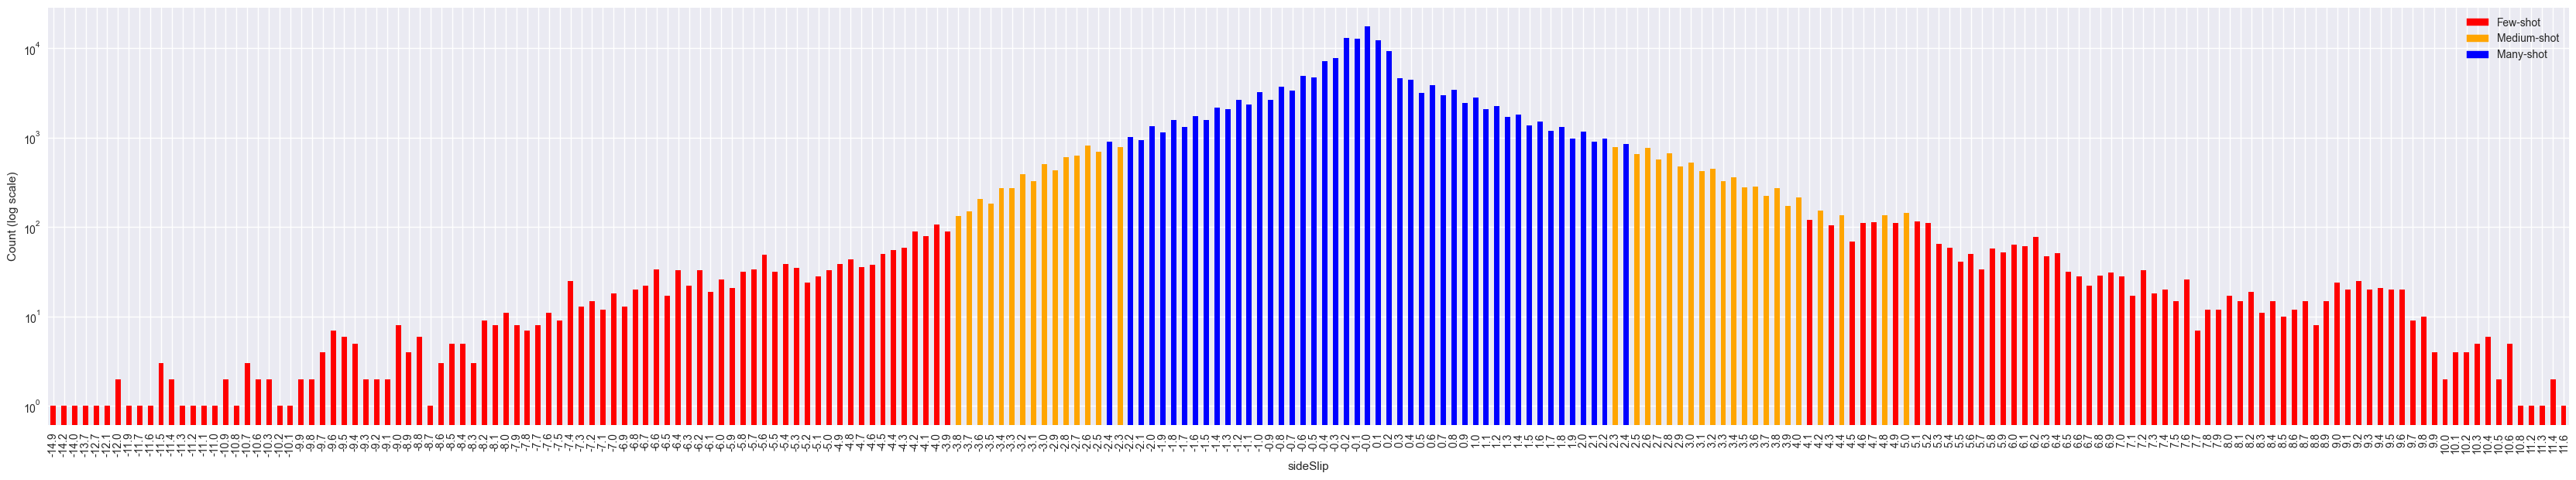

In [22]:
import matplotlib.patches as mpatches
shot_band_mapping = dist_df.groupby("sideSlip")["band"].first()
colors = shot_band_mapping.map({"few": "red", "medium": "orange", "many": "blue"})
ax = dist_df.plot(x='sideSlip', y='count', kind='bar', figsize=(42, 7), fontsize=10, color=colors)
few_patch = mpatches.Patch(color='red', label='Few-shot')
medium_patch = mpatches.Patch(color='orange', label='Medium-shot')
many_patch = mpatches.Patch(color='blue', label='Many-shot')
ax.legend(handles=[few_patch, medium_patch, many_patch], loc='upper right')
plt.yscale('log')
plt.ylabel('Count (log scale)')
plt.show()

**Key Observations from the Chart Above:**

1. **Logarithmic Scale**: The y-axis uses log scale because the difference between many-shot and few-shot is enormous (note how few-shot bars are barely visible!)

2. **Peak at Zero**: The highest bars are around 0° sideslip - this makes sense as most driving happens with minimal sideslip

3. **Symmetric Distribution**: Extreme positive and negative sideslip angles are equally rare (both left and right turns/slides)

4. **The Challenge**: The red bars (few-shot) are tiny but represent the most important scenarios for vehicle safety

Now let's see how this distribution looks in your actual training data. This visualization will help you understand:

- **Where the challenging data points are located** in your training sequences
- **How sparse the few-shot (red) samples are** compared to many-shot (blue)
- **Whether extreme sideslip events cluster together** (hint: they often do during extreme maneuvers)

**What to expect**: You'll see mostly blue dots (normal driving) with occasional orange and red clusters (challenging scenarios like sharp turns, emergency maneuvers, or slippery conditions).

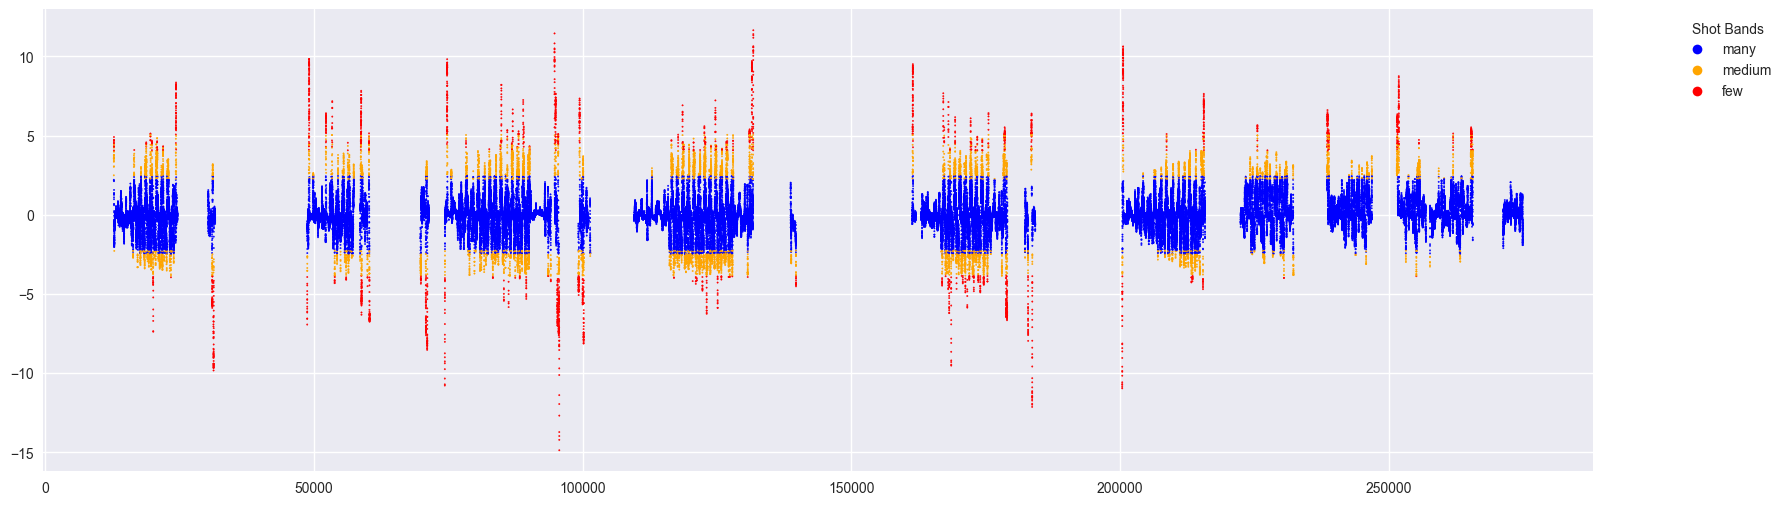

In [23]:
def concate_csv_dir(base_dir):
    all_dfs = []
    csv_lengths = {}
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                relative_path = os.path.relpath(file_path, base_dir)
                csv_lengths[relative_path] = len(df)
                all_dfs.append(df)
    
    return all_dfs, csv_lengths


df_list, csv_lengths = concate_csv_dir("sensing-the-drift/datasets_challenge/train")
train_df = pd.concat(df_list, ignore_index=True)
train_df = train_df.where(train_df["vxCG"] > 3.0).dropna()  # Apply the same thresholding as during training


train_df["band"] = train_df["sideSlip"].round(1).map(shot_band_mapping)

plt.figure(figsize=(20, 6))
plt.scatter(train_df.index, train_df["sideSlip"], c=train_df["band"].map({"many": "blue", "medium": "orange", "few": "red"}), s=1)
# Plot the color code in a legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label='many'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=7, label='medium'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='few')],
           title="Shot Bands", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 🎯 Testing Your Model with the Challenge Metric

Now comes the moment of truth! Let's evaluate your baseline model using the same metric that will be used in the official competition.

**Understanding the Metric:**
- **Dual Evaluation**: You'll get separate MAE scores for many-shot and few-shot regions
- **Success Criteria**: 
  - Few-shot MAE should be as low as possible (this is your primary score)
  - Many-shot MAE must stay ≤ 0.2° (constraint to prevent degradation)
- **Real Competition**: The Kaggle version is slightly different but gives equivalent results

**What to Expect**: Your baseline model will likely show good many-shot performance but struggle with few-shot cases - this is the challenge you need to solve!

In [24]:
from utils.kaggle_metric import score

gt_df = pd.DataFrame({"ground_truth_sideslip": ground_truths}, dtype=np.float64)
gt_df["id"] = range(len(ground_truths))
gt_df["band"] = gt_df["ground_truth_sideslip"].round(1).map(shot_band_mapping).fillna("unknown")


preds_df = pd.DataFrame({"id": range(len(preds)), "predicted_sideslip": preds})

score(gt_df, preds_df, row_id_column_name="id")

band
few       0.444680
many      0.135987
medium    0.235152
Name: L1, dtype: float64

**Performance Analysis:**
- **Many-Shot MAE: ~0.18°** ✅ (Good! Below the 0.2° threshold)
- **Few-Shot MAE: ~1.00°** 🔍 (This is your improvement target)

**What This Tells Us:**
1. **Your model works well for normal driving** - it can predict sideslip accurately when angles are small
2. **Extreme situations are challenging** - the model struggles with rare, critical scenarios
3. **Room for Improvement**: A 5x difference in performance between regions shows the classic imbalanced regression problem

**Data Distribution Context:**
Looking at the data counts below, you can see why this happens - you have ~90% many-shot data vs ~1% few-shot data for training.

**Your Mission in this Challenge**: Can you develop techniques to improve few-shot performance while maintaining many-shot accuracy?

In [25]:
gt_df["band"].value_counts()

band
many      124956
medium      9521
few         2603
Name: count, dtype: int64

And thats all. I hope you now got a feeling for:
- **Data Loading & Preprocessing**: Proper train/validation/test splitting with consistent preprocessing
- **Neural Network Training**: RNN architecture with best practices (early stopping, checkpointing)
- **Model Evaluation**: Understanding training curves and validation metrics  
- **Competition Submission**: Generating predictions in the correct format
- **Imbalanced Regression**: Recognizing and evaluating performance across different data regions

## **Good Luck with the Challange** 🏁